This notebook demonstrates the use of our linear approximation to evalute sensitivity with respect to the Dirichlet process $\alpha$ parameter, in a GMM mixture model of the iris data set.

In [1]:
import jax
from jax import numpy as np
from jax import random

import numpy as onp

from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm.gmm_clustering_lib as gmm_lib
import bnpgmm.utils_lib as utils_lib
import bnpgmm.gmm_optimization_lib as gmm_optim_lib
from bnpgmm import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling import result_loading_utils
from bnpmodeling.bnp_optimization_lib import optimize_kl

# plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

# some other utilities
from copy import deepcopy
import time

/home/rliu/anaconda3/envs/bnp_sensitivity_public/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

The iris data consists of 150 sampled irises; each iris consists of four measurements, 

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

In [3]:
iris_obs.shape

(150, 4)

Text(0, 0.5, 'PC2')

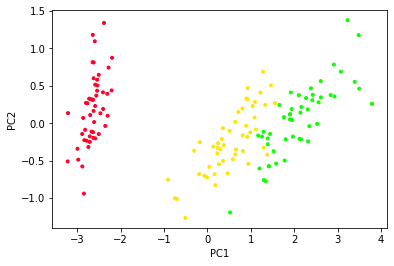

In [4]:
# plot the iris data in PC space
pca_fit, pc_iris_obs, colors1, colors2 = utils_lib.get_plotting_data(iris_obs)

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

The observations are vectors $x_n \in \mathbb{R}^4$, and we model each
component with a multivariate Gaussian. 

Let the $k$-th component have mean $\mu_k$ and covariance $\Lambda_k^{-1}$, so

\begin{align*}
%
P(x_n \vert  \mu_k, \Lambda_k^{-1}, z_n = k) ={}& \text{Normal}(x_n \vert \mu_k, \Lambda_k^{-1}) \\
% 
\end{align*}


The prior on $(\mu_k, \Lambda_k)$ are normal-Wishart, independently for all $k$. 

The cluster assignements $z_n$ are drawn from a multinomial with probabilities $\pi$, with $\pi$ coming from a $\text{GEM}(\alpha)$ distribution. We will evaluate sensitivity to $\alpha$ in this notebook. 

### Prior parameters

In [5]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
alpha0 = 2.0
prior_params_dict['dp_prior_alpha'] = alpha0

# print prior parameters
prior_params_dict

{'dp_prior_alpha': 2.0,
 'prior_centroid_mean': DeviceArray([0.], dtype=float64),
 'prior_lambda': DeviceArray([1.], dtype=float64),
 'prior_wishart_df': DeviceArray([10.], dtype=float64),
 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
              [0., 1., 0., 0.],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.]], dtype=float64)}

### Variational parameters

In [6]:
# number of components in truncated variational distribution 
k_approx = 15

In [7]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In the function above, we return a dictionary of variational parameters, as well as a corresponding `paragami` object. The latter contains methods to constrain (`vb_params_paragami.fold`) and unconstrain (`vb_params_paragami.flatten`) the parameter dictionary. We will use the unconstrained parameterizaiton so we can run unconstrained optimization below. 

See https://paragami.readthedocs.io/en/latest/ for more details about paragami. 

Below, we print the dictionary of variational parameters. In this model, the conditionally conjugate variational distribution on $(\mu_k, \Lambda_k)$ is
normal-Wishart, and the conditionally conjugate variational distribution on $z$ are multinomial.

The variational distribution on the stick-breaking proportions are logit-normal. 

In [9]:
print(vb_params_paragami)

OrderedDict:
	[centroid_params] = OrderedDict:
	[means] = NumericArrayPattern (15, 4) (lb=-inf, ub=inf)
	[lambdas] = NumericArrayPattern (15,) (lb=0.0, ub=inf)
	[wishart_scale] = PatternArray (15,) of PDMatrix 4x4 (diag_lb = 0.0)
	[wishart_df] = NumericArrayPattern (15,) (lb=3, ub=inf)
	[stick_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (14,) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (14,) (lb=0.0001, ub=inf)


Notice that in our parameter dictionary above, we have a dictionary (`centroid_params`) for the normal-Wishart variational parameters, and a dictionary for the logit-normal stick-proportion parameters (`stick_params`). There are no parameters for the multinomial parameters on the cluster assignments: these are set implicitly in evaluating the KL objective. 

In [10]:
# the KL objective that we optimize
gmm_lib.get_kl(iris_obs, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(4495.75192152, dtype=float64)

# Optimize KL objective

### Initialize with K-means

In [11]:
# run a kmeans init
t0 = time.time()
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    gmm_optim_lib.cluster_and_get_k_means_inits(iris_obs,
                                            vb_params_paragami, 
                                            n_kmeans_init = n_kmeans_init, 
                                            seed = 54645)
k_means_time = time.time() - t0
print('elapsed (secs): ', k_means_time)

elapsed (secs):  2.0918712615966797


In [12]:
print('initial kl: ')
print(gmm_lib.get_kl(iris_obs, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
1268.5666580463737


### Optimize the KL with Newton's method 

In [13]:
vb_opt_dict, vb_opt, e_z_opt, out, init_fit_time = \
    gmm_optim_lib.optimize_gmm(iris_obs,
                               init_vb_params_dict,
                               vb_params_paragami,
                               prior_params_dict, 
                               gh_loc, gh_weights, 
                               run_newton = True)

compiling objective and derivatives ... 
done. Compile time: 18.528sec
Running L-BFGS-B ...
L-BFGS-B time: 0.291sec
BFGS out:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Running trust-ncg ... 
Newton time: 0.131sec
Newton out:  Optimization terminated successfully.
done. 


In [14]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [15]:
paragami.save_folded('./initial_fit', 
                     vb_opt_dict, 
                     vb_params_paragami, 
                     final_kl = out.fun, 
                     alpha0 = alpha0)

# Check initial fit

In [16]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    
    means = vb_params_dict['centroid_params']['means']
    infos = np.einsum('k, kij -> kij', 
                      vb_params_dict['centroid_params']['wishart_df'], 
                      vb_params_dict['centroid_params']['wishart_scale'])
    
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, means, np.linalg.inv(infos))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])
    
    return bnp_centroids_pc, bnp_cluster_covs_pc

### Plot centroids

Text(0, 0.5, 'PC2')

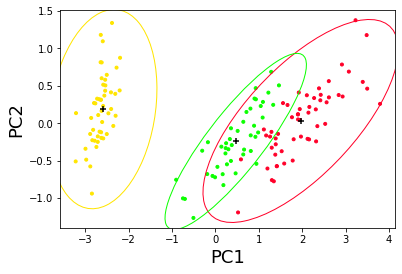

In [17]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

bnp_centroids_pc, bnp_cluster_covs_pc = \
    plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


### Plot mixture weights

In [18]:
def get_e_num_obs_per_cluster(vb_params_dict): 
    
    ez = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_params_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)
    return ez.sum(0)

In [19]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt_dict)
mixture_weights = gmm_posterior_quantities_lib.get_e_mixture_weights_from_vb_dict(vb_opt_dict, gh_loc, gh_weights)

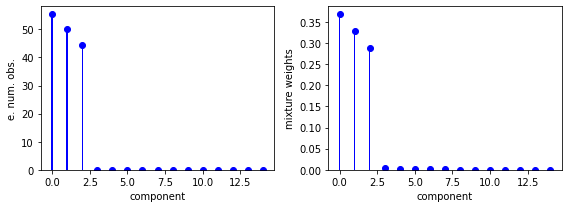

In [20]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()

# Parametric sensitivity

### Compute derivatives for linear approximation

We first need to define our objective as a function of both the (unconstrained) variational parameters and the prior parameter $\alpha$. 

In [21]:
# set up objective as function of vb parameter dictionary and prior parameter

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return gmm_lib.get_kl(iris_obs, 
                          vb_params_dict,
                          _prior_params_dict,
                          gh_loc, gh_weights).squeeze()

# now define the same objective, but as a function of the unconstrained dicionary
objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 0)

In [22]:
# the linear sensitivity class: computes the cross-hessian and solves the linear system
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        alpha0)

Compiling hessian solver ...
Hessian solver compile time: 34.0321sec

Compiling cross hessian...
Cross-hessian compile time: 0.466207sec

LR sensitivity time: 0.0196416sec



In [23]:
vb_sens.lr_time

0.019641637802124023

### re-fit for a range of alpha

In [24]:
# define the range of alpha
alpha_list = np.arange(0, 4.2, step = 0.4)

# set the smallest to 0.01, not zero
alpha_list = np.clip(alpha_list, a_min  = 0.01)

In [25]:
alpha_list

DeviceArray([0.01, 0.4 , 0.8 , 1.2 , 1.6 , 2.  , 2.4 , 2.8 , 3.2 , 3.6 ,
             4.  ], dtype=float64)

You may have noticed in the functions above that there is a first compiliation step that is often slow. 

The functions are fast after the compilation, and it is these post-compilation times that we record in our paper. 
(we ignore compilation times for both optimization and the linear approximation, so the comparisons are fair). 

Next, we will repeatedly optimize the KL objective for a range of $\alpha$. Thus, we will compile what we can first, before looping through our set of perturbed $\alpha$'s. 

In [26]:
# define and compile the gradient and the hessian vector product. 

get_grad = jax.jit(jax.grad(objective_fun_free, argnums = 0))

def _get_hvp(x, alpha, v):
    return jax.jvp(jax.grad(objective_fun_free, argnums = 0), (x, alpha), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)

In [27]:
# compile the gradient and hessian
print('compiling ... ')
_ = get_grad(vb_opt, alpha_list[0]).block_until_ready()
_ = get_hvp(vb_opt, alpha_list[0], vb_opt).block_until_ready()
print('done. ')

compiling ... 
done. 


### a wrapper for re-optimization

In [28]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    _, vb_opt_pert, _, refit_time = \
        optimize_kl(lambda x : objective_fun_free(x, alpha),
                     new_init_dict, 
                     vb_params_paragami, 
                     get_grad = lambda x : get_grad(x, alpha),
                     get_hvp = lambda x, v: get_hvp(x, alpha, v),
                     run_lbfgs = False,
                     run_newton = True)                            
        
    return vb_opt_pert, refit_time

### re-optimize

In [29]:
refit_list = []
refit_time_vec = []

new_init_dict = deepcopy(vb_opt_dict)

for alpha in alpha_list: 
    print('\n################')
    print('re-optimzing with alpha = ', alpha)
    print('################')
    
    vb_opt_pert, refit_time = refit_with_alpha(alpha, new_init_dict)
    
    refit_list.append(vb_opt_pert)
    refit_time_vec.append(refit_time)


refit_time_vec = onp.array(refit_time_vec)


################
re-optimzing with alpha =  0.01
################
compiling objective and derivatives ... 
done. Compile time: 1.064sec
Running trust-ncg ... 
Newton time: 1.669sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  0.4
################
compiling objective and derivatives ... 
done. Compile time: 1.089sec
Running trust-ncg ... 
Newton time: 0.329sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  0.8
################
compiling objective and derivatives ... 
done. Compile time: 1.046sec
Running trust-ncg ... 
Newton time: 0.226sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  1.2000000000000002
################
compiling objective and derivatives ... 
done. Compile time: 1.055sec
Running trust-ncg ... 
Newton time: 0.197sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzi

# Get linear response for each alpha

In [30]:
lr_list = []
lr_time_vec = []

for alpha in alpha_list: 
        
    # get linear appxoimation
    t0 = time.time() 
    _alpha = np.array([alpha])
    lr_free_params = vb_sens.predict_opt_par_from_hyper_par(_alpha)
    elapsed = time.time() - t0
    
    # save
    lr_list.append(lr_free_params)
    lr_time_vec.append(elapsed)
    
lr_time_vec = onp.array(lr_time_vec)

In [31]:
print('Total lin. approx time: ', lr_time_vec.sum(), 'secs')

Total lin. approx time:  0.027171611785888672 secs


# Check results on number of clusters

We consider two posterior quantities: 
the expected number of in-sample clusters and 
the expected number of predictive clusters. 

Let $G(z) = \sum_{k} 1\{\sum_{n} z_{nk} > 0\}$ be the number of clusters as a function of the cluster assignments $z$.
- Here, $z_{nk} = 1$ if the $n$-th iris belongs to component $k$, and $1\{\cdot\}$ is the indicator function. 

The expected **in-sample** number of clusters is the expectation of $G(z)$ under the approximate posterior, 
\begin{align*}
    E[\text{num. in-sample clusters}] = E_{q(z)}[G(z)].
\end{align*}

The expected **predictive** number of clusters is the number of clusters we would expect to see in a new sample of of $N$ iris flowers. This is given by 

\begin{align*}
    E[\text{num. predictive clusters}] = E_{q(\pi)}[E_{p(z|\pi)}[G(z)]],
\end{align*}
where recall that $\pi$ are the latent mixture weights. 


    

In [32]:
prng_key = jax.random.PRNGKey(223)

@jax.jit
def get_n_clusters_insample(vb_free):
    # the expected number of in-sample clusters as a function of the 
    # flattened vb parameters
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_clusters_from_vb_dict(iris_obs,
                                                    vb_params_dict,
                                                    gh_loc, gh_weights,
                                                    threshold = 0,
                                                    n_samples = 10000, 
                                                    prng_key = prng_key)

@jax.jit
def get_n_clusters_pred(vb_free):
    # the expected number of predictive clusters
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_posterior_quantities_lib.get_e_num_pred_clusters_from_vb_dict(vb_params_dict,
                                                               n_obs = iris_obs.shape[0],
                                                               threshold = 0,
                                                               prng_key = prng_key)

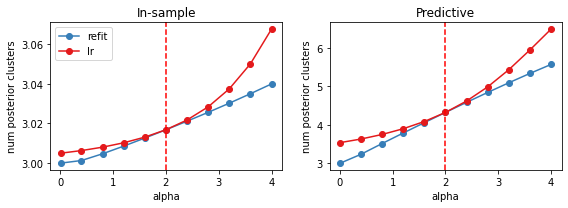

In [36]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
axarr[0].legend()
axarr[0].set_title('In-sample')

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])
axarr[1].set_title('Predictive')

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')
    axarr[i].set_xlabel('alpha')
    axarr[i].set_ylabel('num posterior clusters')

fig.tight_layout()